# FIFA-MoneyBall project

In [48]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import statsmodels.api as sm
pd.set_option('display.max_rows', 500)

In [49]:
# For this lab, we still keep using the marketing_customer_analysis.csv file that you can find in the files_for_lab folder.

# It's time to put it all together. Remember the previous rounds and follow the steps as shown in previous lectures.

# 01 - Problem (case study)
    # Data Description.
    # Goal.
    
# 02 - Getting Data
    # Read the .csv file.
    
# 03 - Cleaning/Wrangling/EDA
    # Change headers names.
    # Deal with NaN values.
    # Categorical Features.
    # Numerical Features.
    # Exploration.
    
# 04 - Processing Data
    # Dealing with outliers.
    # Normalization.
    # Encoding Categorical Data.
    # Splitting into train set and test set.
    
# 05 - Modeling
    # Apply model.
    
# 06 - Model Validation
    # R2.
    # MSE.
    # RMSE.
    # MAE.
    
# 07 - Reporting
    # Present results.

In [142]:
# Functions for processing
def import_to_df(csv_file):
    df = pd.read_csv(csv_file)
#     df = df.drop(['Unnamed: 0'], axis = 1)
    return df
  

# 03 - Cleaning/Wrangling/EDA
    # Change column names.
    
def reformat_columns(df):
    df_copy = df.copy()
    df_copy.columns = df_copy.columns.str.lower().str.replace(' ', '_')
    return df_copy   
    
    # Deal with NaN values.
    
def convert_to_euros(value):
    if value.endswith('M'):
        return float(value[:-1]) * 1000000
    elif value.endswith('K'):
        return float(value[:-1]) * 1000
    else:
        return value
    
def check_nan_values(df):
    null_df = df.isna().sum()/len(df)*100
    print('The percentage of NaN values per column is:\n',null_df)
    
def remove_nan_cols(df, percentage_nan):
    df_copy = df.copy()
    null_df = df.isna().sum()/len(df)*100
    for item in null_df.index:
        if null_df.loc[item] > percentage_nan:
            df_copy.drop([item], inplace=True, axis=1)
            print("Dropping column:", item, "due to percentage of NaN values greater than:", percentage_nan) 
    return df_copy  

def remove_nan_rows(df):
    df_copy = df.copy()
    return df_copy.dropna()

# 03 - Cleaning/Wrangling/EDA
    # Outliers???
# def filter_outliers(df, threshold):
#     mask = pd.Series(data=True, index=df.index)
#     for col in df.columns:
#         q1 = df[col].quantile(0.25)
#         q3 = df[col].quantile(0.75)
#         iqr = q3 - q1
#         lower_limit = q1 - (threshold * iqr)
#         upper_limit = q3 + (threshold * iqr)
#         col_mask = (df[col] >= lower_limit) & (df[col] <= upper_limit)
#         mask = mask & col_mask
#     return df[mask]
    
    # Categorical Features. Numerical Features.
    
def to_object(df, col1, col2):
    df[col1] = df[col1].astype(str)
    df[col2] = df[col2].astype(str)
    return df   
    
def split_categorical_numerical(df):
    categorical_df = df.select_dtypes(include=['object'])
    numerical_df = df.select_dtypes(exclude=['object'])
    return categorical_df, numerical_df
    
    # Exploration.
        
# 04 - Processing Data
    # Dealing with outliers.
    # Normalization.
    
def split_numerical(numerical_df, y_var):
    df_copy = numerical_df.copy()
    x = df_copy.drop(y_var, axis=1)
    y = df_copy[y_var]
    return x,y

# ax = sns.scatterplot(x = 'ova', y = 'pot', data=df_numeric_filtered)

def plot_scatter(df):
    num_cols = len(df.columns)
    num_subplots = num_cols // 2 + num_cols % 2
    fig, axis = plt.subplots(2,num_subplots, figsize=(12,8))  
    axis = axis.ravel()
    for i, col in enumerate(df.columns):
        sns.scatterplot(x = df[col], y = 'pot', data=df, ax = axis[i]).set_xlabel(col)    
    plt.tight_layout()
    plt.show()

def plot_hist(df):
    num_cols = len(df.columns)
    num_subplots = num_cols // 2 + num_cols % 2
    fig, axis = plt.subplots(2,num_subplots, figsize=(12,8))  
    axis = axis.ravel()
    for i, col in enumerate(df.columns):
        sns.histplot(df[col], kde=True, ax = axis[i]).set_xlabel(col)     
    plt.tight_layout()
    plt.show()
    
def plot_box(df):
    num_cols = len(df.columns)
    num_subplots = num_cols // 2 + num_cols % 2
    fig, axis = plt.subplots(2,num_subplots, figsize=(12,8))  
    axis = axis.ravel()
    for i, col in enumerate(df.columns):
        sns.boxplot(x = df[col], ax = axis[i]).set_xlabel(col)     
    plt.tight_layout()
    plt.show() 
    
def replace_inf(i):
    if np.isfinite(i):
        return i
    else:
        return np.NAN    
    
def log_transformer(df, cols_to_log):
    df_copy = df.copy()
    for col in cols_to_log:
        df_copy[col] = np.log(df_copy[col])
        df_copy[col] = list(map(replace_inf, df_copy[col]))
        df_copy[col] = df_copy[col].fillna(df_copy[col].mean())
    return df_copy

def box_cox_transformer(df, cols_to_transform):
    df_copy = df.copy()
    for col in cols_to_transform:
        df_copy[col] = np.where(df_copy[col] <= 0, 0, df_copy[col])
        df_copy[col].replace(0,df[col].mean(), inplace=True)
        transformed_col, _ = stats.boxcox(df_copy[col])
        df_copy[col] = transformed_col
    return df_copy

def min_max_scaler(df):
    df_copy = pd.DataFrame(MinMaxScaler().fit(df).transform(df))
    return df_copy

def standard_scaler(df):
    columns = df.columns
    df_copy = pd.DataFrame(StandardScaler().fit(df).transform(df))
    df_copy.columns = columns
    return df_copy

    # Encoding Categorical Data.
    # Splitting into train set and test set.    
    

def label_encoder(df, label_encoder_cols):
    df_copy = df.copy()
    for col in label_encoder_cols:
        df_copy[col] = LabelEncoder().fit(df_copy[col]).transform(df_copy[col])
    return df_copy

def one_hot_encoder(df, one_hot_cols):
    df_encoded = df.copy()
    encoder = OneHotEncoder()
    encoder.fit(df_encoded[one_hot_cols].values)
    encoded = encoder.transform(df_encoded[one_hot_cols].values)
    encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(one_hot_cols))
    df_encoded = pd.concat([df_encoded, encoded_df], axis=1)
    df_encoded = df_encoded.drop(one_hot_cols, axis=1)
    return df_encoded       
        
def concat_df(df1, df2):
    df2 = df2.reset_index(drop=True)
    df_combined = pd.concat([df1, df2], axis=1, ignore_index=True)
    df_combined = sm.add_constant(df_combined)
    return df_combined

# def train_test_split(X, y, test_size=0.4, random_state=50):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,random_state=random_state)
#     return X_train, y_train, X_test, y_test

def linear_regression(X, y):
    X = sm.add_constant(X) # Add a constant tern to the input data
    model = sm.OLS(y, X).fit()
    return model

def make_predictions(model, data):
    data = sm.add_constant(data) # Add a constant tern to the input data
    predictions = model.predict(data)
    return predictions
    
                   
def model_metrics(X, y, model):
    X = sm.add_constant(X) # Add a constant tern to the input data
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    print('R2 Score: {:.3f}'.format(r2), '\nMean Squared Error: {:.3f}'.format(mse), '\nRoot MSE: {:.3f}'.format(rmse), '\nMean Absolute Error: {:.3f}'.format(mae) )


In [51]:
# Import raw data
df = import_to_df('fifa21_male2.csv')

C:\Users\pgarciag\AppData\Local\Temp\ipykernel_20580\2624983234.py:3: DtypeWarning: Columns (78) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)


In [52]:
df.head(500)


,ID,Name,Age,OVA,Nationality,Club,BOV,BP,Position,Player Photo,...,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,GK,Gender
0,2,G. Pasquale,33,69,Italy,Udinese,71,LWB,LM,https://cdn.sofifa.com/players/000/002/16_120.png,...,70+-1,70+-1,71+-2,70+-1,69+0,69+0,69+0,70+-1,17+0,Male
1,16,Luis García,37,71,Spain,KAS Eupen,70,CM,CM CAM CDM,https://cdn.sofifa.com/players/000/016/19_120.png,...,66+1,66+1,62+1,60+1,60+1,60+1,60+1,60+1,17+1,Male
2,27,J. Cole,33,71,England,Coventry City,71,CAM,CAM RM RW LM,https://cdn.sofifa.com/players/000/027/16_120.png,...,54+0,54+0,52+0,47+0,46+0,46+0,46+0,47+0,15+0,Male
3,36,D. Yorke,36,68,Trinidad &amp; Tobago,Sunderland,70,ST,NaN,https://cdn.sofifa.com/players/000/036/09_120.png,...,65+0,65+0,56+0,57+0,51+0,51+0,51+0,57+0,22+0,Male
4,41,Iniesta,36,81,Spain,Vissel Kobe,82,CAM,CM CAM,https://cdn.sofifa.com/players/000/041/20_120.png,...,73+3,73+3,70+3,67+3,64+3,64+3,64+3,67+3,17+3,Male
5,61,D. Odonkor,27,66,Germany,Alemannia Aachen,66,RW,RW RM,https://cdn.sofifa.com/players/000/061/12_120.png,...,47+0,47+0,50+0,46+0,41+0,41+0,41+0,46+0,13+0,Male
6,80,E. Belözoğlu,38,77,Turkey,Fenerbahçe SK,77,CM,CM CDM,https://cdn.sofifa.com/players/000/080/20_120.png,...,72+2,72+2,66+2,64+2,65+2,65+2,65+2,64+2,16+2,Male
7,241,R. Giggs,39,78,Wales,Manchester United,78,CAM,LM CM CAM,https://cdn.sofifa.com/players/000/241/14_120.png,...,63+1,63+1,62+1,57+1,53+1,53+1,53+1,57+1,11+1,Male
8,244,G. Neville B,35,76,England,Manchester United,78,CB,RB CB RWB,https://cdn.sofifa.com/players/000/244/11_120.png,...,74+0,74+0,73+0,76+0,78+0,78+0,78+0,76+0,13+0,Male
9,246,P. Scholes,37,80,England,Manchester United,82,CAM,CM CDM,https://cdn.sofifa.com/players/000/246/13_120.png,...,75+0,75+0,67+0,64+0,64+0,64+0,64+0,64+0,15+0,Male


In [53]:
#Reformat columns to lower case and remove spaces
df = reformat_columns(df)

In [54]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,17125.0,219388.716204,37499.197507,2.0,204082.0,228961.0,243911.0,259105.0
age,17125.0,25.272934,4.942665,16.0,21.0,25.0,29.0,53.0
ova,17125.0,66.965022,6.864329,38.0,62.0,67.0,72.0,93.0
bov,17125.0,67.900204,6.637538,42.0,64.0,68.0,72.0,93.0
pot,17125.0,72.489810,5.769949,47.0,69.0,72.0,76.0,95.0
growth,17125.0,5.524788,5.787539,-1.0,0.0,4.0,9.0,26.0
attacking,17125.0,258.537752,72.255687,33.0,232.0,271.0,306.0,437.0
crossing,17125.0,51.621314,17.875715,6.0,41.0,56.0,65.0,94.0
finishing,17125.0,47.956672,19.391547,3.0,33.0,52.0,64.0,95.0
heading_accuracy,17125.0,53.598832,16.947164,5.0,46.0,57.0,65.0,93.0


In [55]:
df.dtypes

id                    int64
name                 object
age                   int64
ova                   int64
nationality          object
club                 object
bov                   int64
bp                   object
position             object
player_photo         object
club_logo            object
flag_photo           object
pot                   int64
team_&_contract      object
height               object
weight               object
foot                 object
growth                int64
joined               object
loan_date_end        object
value                object
wage                 object
release_clause       object
contract             object
attacking             int64
crossing              int64
finishing             int64
heading_accuracy      int64
short_passing         int64
volleys             float64
skill                 int64
dribbling             int64
curve               float64
fk_accuracy           int64
long_passing          int64
ball_control        

In [56]:
# Change data types from Categorical to Numerical for the following columns: 'value', 'wage', 'release_clause', 'hits'
df['value'] = df.value.str.replace('€', '')
df['value']  = df.value.apply(convert_to_euros)

df['wage'] = df.wage.str.replace('€', '')
df['wage']  = df.wage.apply(convert_to_euros)

df['release_clause'] = df.release_clause.str.replace('€', '')
df['release_clause']  = df.release_clause.apply(convert_to_euros)

df['value'] = pd.to_numeric(df['value'], errors='coerce')
df['wage'] = pd.to_numeric(df['wage'], errors='coerce')
df['release_clause'] = pd.to_numeric(df['release_clause'], errors='coerce')
df['hits'] = pd.to_numeric(df['hits'], errors='coerce')

In [57]:
df.dtypes

id                    int64
name                 object
age                   int64
ova                   int64
nationality          object
club                 object
bov                   int64
bp                   object
position             object
player_photo         object
club_logo            object
flag_photo           object
pot                   int64
team_&_contract      object
height               object
weight               object
foot                 object
growth                int64
joined               object
loan_date_end        object
value               float64
wage                float64
release_clause      float64
contract             object
attacking             int64
crossing              int64
finishing             int64
heading_accuracy      int64
short_passing         int64
volleys             float64
skill                 int64
dribbling             int64
curve               float64
fk_accuracy           int64
long_passing          int64
ball_control        

In [58]:
# Separate categorical and numerical columns

df_categorical = df.select_dtypes(include = 'object')
df_numeric = df.select_dtypes(exclude = 'object')
df_categorical.head()

,name,nationality,club,bp,position,player_photo,club_logo,flag_photo,team_&_contract,height,...,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,gender
0,G. Pasquale,Italy,Udinese,LWB,LM,https://cdn.sofifa.com/players/000/002/16_120.png,https://cdn.sofifa.com/teams/55/light_60.png,https://cdn.sofifa.com/flags/it.png,Udinese 2008 ~ 2016,"6'0""",...,70+-1,70+-1,71+-2,70+-1,69+0,69+0,69+0,70+-1,17+0,Male
1,Luis García,Spain,KAS Eupen,CM,CM CAM CDM,https://cdn.sofifa.com/players/000/016/19_120.png,https://cdn.sofifa.com/teams/2013/light_60.png,https://cdn.sofifa.com/flags/es.png,KAS Eupen 2014 ~ 2019,"5'10""",...,66+1,66+1,62+1,60+1,60+1,60+1,60+1,60+1,17+1,Male
2,J. Cole,England,Coventry City,CAM,CAM RM RW LM,https://cdn.sofifa.com/players/000/027/16_120.png,https://cdn.sofifa.com/teams/1800/light_60.png,https://cdn.sofifa.com/flags/gb-eng.png,Coventry City 2016 ~ 2020,"5'9""",...,54+0,54+0,52+0,47+0,46+0,46+0,46+0,47+0,15+0,Male
3,D. Yorke,Trinidad &amp; Tobago,Sunderland,ST,NaN,https://cdn.sofifa.com/players/000/036/09_120.png,https://cdn.sofifa.com/teams/106/light_60.png,https://cdn.sofifa.com/flags/tt.png,Sunderland 2009,"5'11""",...,65+0,65+0,56+0,57+0,51+0,51+0,51+0,57+0,22+0,Male
4,Iniesta,Spain,Vissel Kobe,CAM,CM CAM,https://cdn.sofifa.com/players/000/041/20_120.png,https://cdn.sofifa.com/teams/101146/light_60.png,https://cdn.sofifa.com/flags/es.png,Vissel Kobe 2018 ~ 2021,"5'7""",...,73+3,73+3,70+3,67+3,64+3,64+3,64+3,67+3,17+3,Male


In [59]:
df_numeric.head(500)

,id,age,ova,bov,pot,growth,value,wage,release_clause,attacking,...,gk_reflexes,total_stats,base_stats,pac,sho,pas,dri,def,phy,hits
0,2,33,69,71,69,0,625000.0,7000.0,0.0,313,...,12,1929,408,71,59,70,71,68,69,4.0
1,16,37,71,70,71,0,600000.0,7000.0,1100000.0,337,...,11,1906,385,53,69,73,69,58,63,4.0
2,27,33,71,71,71,0,1100000.0,15000.0,0.0,337,...,7,1770,354,45,68,76,77,36,52,11.0
3,36,36,68,70,82,14,0.0,0.0,0.0,264,...,21,1348,369,61,66,66,69,47,60,3.0
4,41,36,81,82,81,0,5500000.0,12000.0,7200000.0,367,...,7,2014,420,58,70,85,85,63,59,149.0
5,61,27,66,66,70,4,725000.0,5000.0,0.0,271,...,9,1649,360,91,56,56,67,27,63,7.0
6,80,38,77,77,77,0,2800000.0,44000.0,5300000.0,342,...,8,2017,403,44,71,83,77,62,66,7.0
7,241,39,78,78,78,0,1000.0,60000.0,0.0,380,...,5,1939,392,60,72,85,77,41,57,9.0
8,244,35,76,78,82,6,0.0,0.0,0.0,304,...,11,1774,378,67,36,67,53,81,74,4.0
9,246,37,80,82,80,0,400000.0,40000.0,0.0,394,...,8,2065,415,53,76,87,79,59,61,7.0


In [60]:
# Create Correlation matrix to select which columns/attributes have the highest influence in 'potential'
corr_df = df_numeric.corr()
corr_df.head(10000)

,id,age,ova,bov,pot,growth,value,wage,release_clause,attacking,...,gk_reflexes,total_stats,base_stats,pac,sho,pas,dri,def,phy,hits
id,1.000000,-0.743844,-0.431079,-0.385713,0.042604,0.553757,-0.094638,-0.222340,-0.068069,-0.178002,...,-0.094745,-0.236634,-0.339341,0.175293,-0.284713,-0.366366,-0.232583,-0.165248,-0.295857,0.032869
age,-0.743844,1.000000,0.517099,0.456734,-0.237619,-0.850204,0.095981,0.200851,0.075386,0.183954,...,0.121822,0.280383,0.414897,-0.177291,0.309438,0.396082,0.241027,0.223184,0.436462,-0.097518
ova,-0.431079,0.517099,1.000000,0.985877,0.592268,-0.595585,0.631679,0.592925,0.597617,0.431238,...,0.037284,0.607676,0.832618,0.201319,0.487060,0.699229,0.643427,0.344906,0.543354,0.374210
bov,-0.385713,0.456734,0.985877,1.000000,0.628323,-0.542890,0.640818,0.592453,0.608384,0.464329,...,-0.008819,0.635037,0.830127,0.212889,0.478573,0.689975,0.640746,0.349906,0.535579,0.399528
pot,0.042604,-0.237619,0.592268,0.628323,1.000000,0.294499,0.563570,0.462235,0.549201,0.233866,...,-0.005215,0.329178,0.474763,0.259294,0.244481,0.395773,0.445004,0.170562,0.159959,0.520248
growth,0.553757,-0.850204,-0.595585,-0.542890,0.294499,1.000000,-0.187347,-0.242411,-0.161274,-0.278316,...,-0.049419,-0.392559,-0.514210,0.019730,-0.333941,-0.434753,-0.319487,-0.239034,-0.484974,0.070853
value,-0.094638,0.095981,0.631679,0.640818,0.563570,-0.187347,1.000000,0.822728,0.979295,0.289886,...,0.002476,0.393043,0.526843,0.210809,0.323770,0.444484,0.442156,0.172856,0.266541,0.616474
wage,-0.222340,0.200851,0.592925,0.592453,0.462235,-0.242411,0.822728,1.000000,0.798432,0.288541,...,-0.012639,0.379345,0.479638,0.122591,0.294205,0.419563,0.389842,0.191576,0.260983,0.500832
release_clause,-0.068069,0.075386,0.597617,0.608384,0.549201,-0.161274,0.979295,0.798432,1.000000,0.269036,...,0.004309,0.368406,0.497094,0.200583,0.300981,0.418093,0.416343,0.167362,0.250809,0.620867
attacking,-0.178002,0.183954,0.431238,0.464329,0.233866,-0.278316,0.289886,0.288541,0.269036,1.000000,...,-0.760922,0.903393,0.428602,0.180335,0.351248,0.373439,0.381863,0.106978,0.104102,0.191418


In [168]:
# Filter correlation matrix so we only keep correlation values greater than ABS(0.5) (Moderate correlation)

corr_df_filtered = corr_df[corr_df['pot'] >= abs(0.4)]
corr_df_filtered.head(500)

,id,age,ova,bov,pot,growth,value,wage,release_clause,attacking,...,gk_reflexes,total_stats,base_stats,pac,sho,pas,dri,def,phy,hits
ova,-0.431079,0.517099,1.000000,0.985877,0.592268,-0.595585,0.631679,0.592925,0.597617,0.431238,...,0.037284,0.607676,0.832618,0.201319,0.487060,0.699229,0.643427,0.344906,0.543354,0.374210
bov,-0.385713,0.456734,0.985877,1.000000,0.628323,-0.542890,0.640818,0.592453,0.608384,0.464329,...,-0.008819,0.635037,0.830127,0.212889,0.478573,0.689975,0.640746,0.349906,0.535579,0.399528
pot,0.042604,-0.237619,0.592268,0.628323,1.000000,0.294499,0.563570,0.462235,0.549201,0.233866,...,-0.005215,0.329178,0.474763,0.259294,0.244481,0.395773,0.445004,0.170562,0.159959,0.520248
value,-0.094638,0.095981,0.631679,0.640818,0.563570,-0.187347,1.000000,0.822728,0.979295,0.289886,...,0.002476,0.393043,0.526843,0.210809,0.323770,0.444484,0.442156,0.172856,0.266541,0.616474
wage,-0.222340,0.200851,0.592925,0.592453,0.462235,-0.242411,0.822728,1.000000,0.798432,0.288541,...,-0.012639,0.379345,0.479638,0.122591,0.294205,0.419563,0.389842,0.191576,0.260983,0.500832
release_clause,-0.068069,0.075386,0.597617,0.608384,0.549201,-0.161274,0.979295,0.798432,1.000000,0.269036,...,0.004309,0.368406,0.497094,0.200583,0.300981,0.418093,0.416343,0.167362,0.250809,0.620867
reactions,-0.421033,0.501010,0.870084,0.870157,0.471139,-0.562259,0.559096,0.531624,0.529609,0.444720,...,-0.018619,0.604811,0.745003,0.119627,0.449776,0.625112,0.570761,0.335554,0.494545,0.328524
base_stats,-0.339341,0.414897,0.832618,0.830127,0.474763,-0.514210,0.526843,0.479638,0.497094,0.428602,...,0.095182,0.678885,1.000000,0.436092,0.620905,0.850971,0.802708,0.326539,0.487524,0.314533
dri,-0.232583,0.241027,0.643427,0.640746,0.445004,-0.319487,0.442156,0.389842,0.416343,0.381863,...,0.162535,0.494865,0.802708,0.521642,0.765627,0.823216,1.000000,-0.153362,0.024540,0.288750
hits,0.032869,-0.097518,0.374210,0.399528,0.520248,0.070853,0.616474,0.500832,0.620867,0.191418,...,-0.035187,0.248055,0.314533,0.188020,0.173052,0.253134,0.288750,0.093164,0.120371,1.000000


In [62]:
# Filter original data frame so we only keep columns with the highest correlation

df_numeric_filtered = df.loc[:, ['ova', 'bov', 'pot', 'value', 'release_clause', 'hits']]


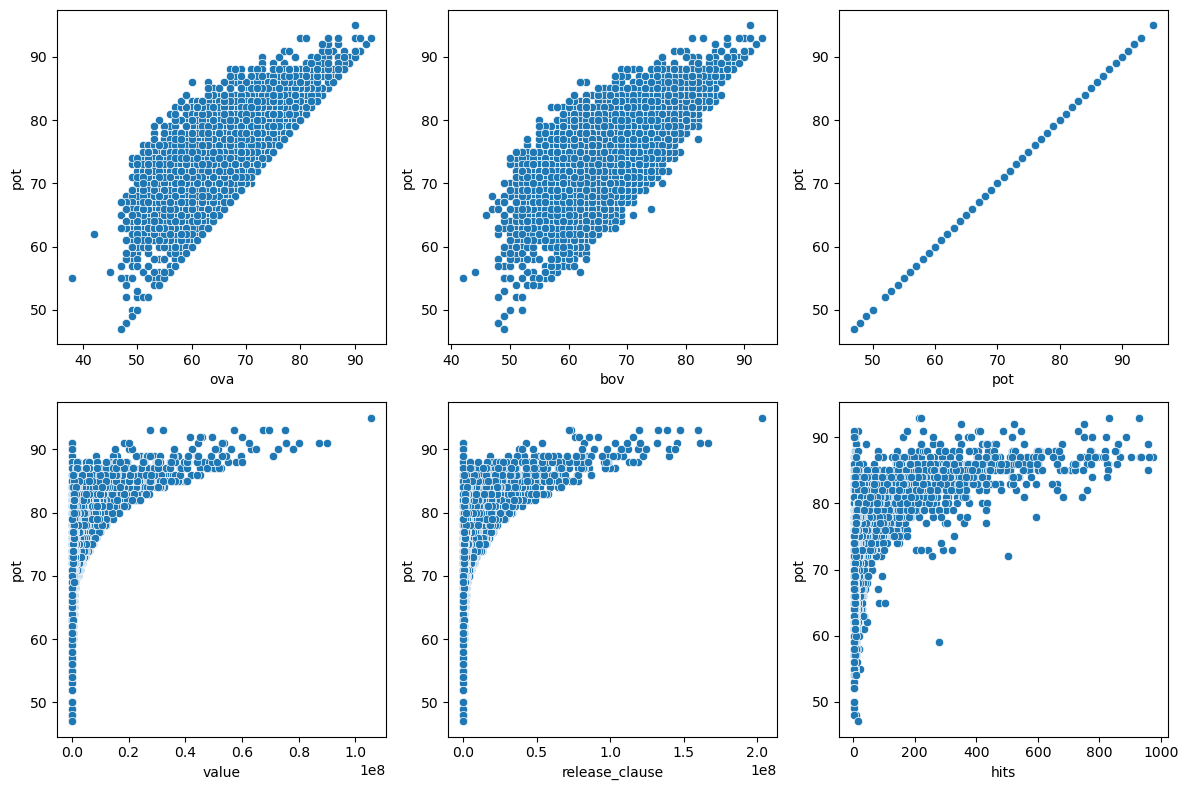

In [63]:
# Create scatter plots of the selected independent variables with respect to 'potential'
plot_scatter(df_numeric_filtered)

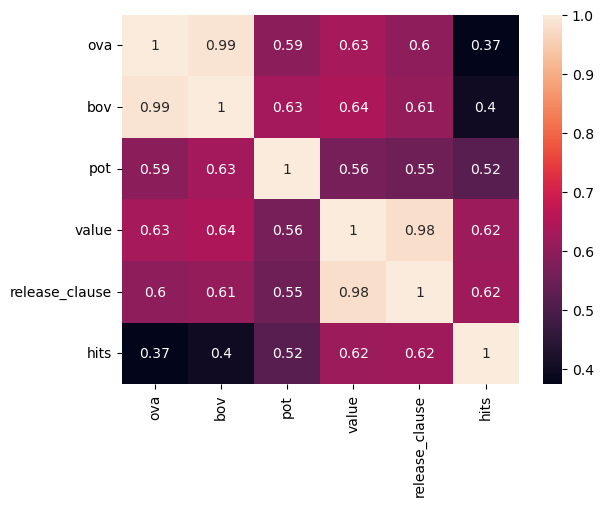

In [64]:
heatmap = sns.heatmap(df_numeric_filtered.corr(), annot=True)

In [65]:
check_nan_values(df_numeric_filtered)
df_numeric_filtered['hits'] = df_numeric_filtered['hits'].fillna(0)
check_nan_values(df_numeric_filtered)

The percentage of NaN values per column is:
 ova               0.000000
bov               0.000000
pot               0.000000
value             0.000000
release_clause    0.000000
hits              0.373723
dtype: float64
The percentage of NaN values per column is:
 ova               0.0
bov               0.0
pot               0.0
value             0.0
release_clause    0.0
hits              0.0
dtype: float64


In [110]:
# Drop numeric values that are highly correlated with each other:

df_num_1 = df_numeric_filtered.drop(['release_clause','bov'], axis =1) # Only OVA, Value and Hits
df_num_2 = df_numeric_filtered.drop(['release_clause','bov', 'hits'], axis =1) # Only OVA and Value
df_num_3 = df_numeric_filtered.drop(['release_clause','ova', 'hits'], axis =1) # Only BOV and Value

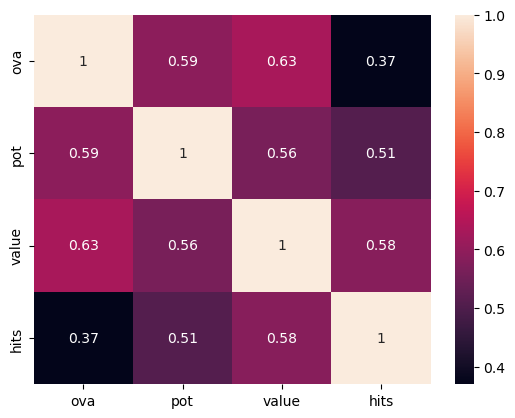

In [111]:
heatmap = sns.heatmap(df_num_1.corr(), annot=True)

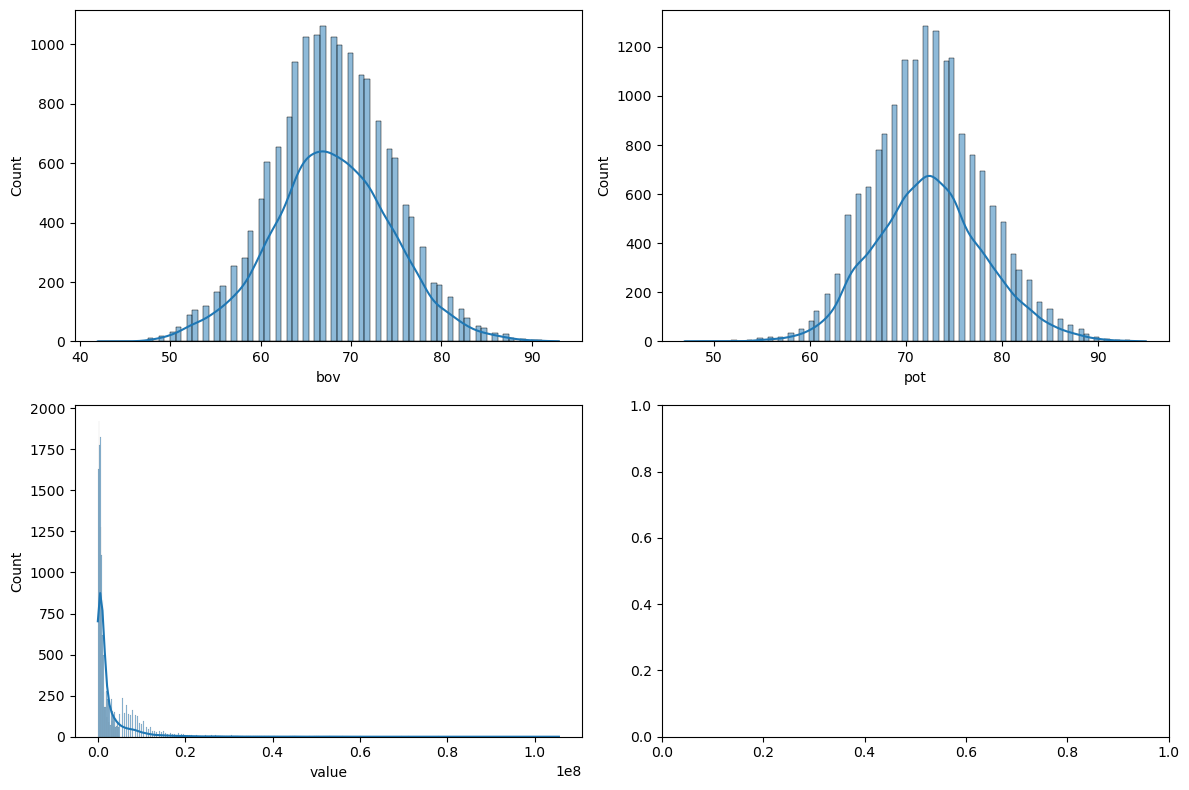

In [112]:
plot_hist(df_num_3)

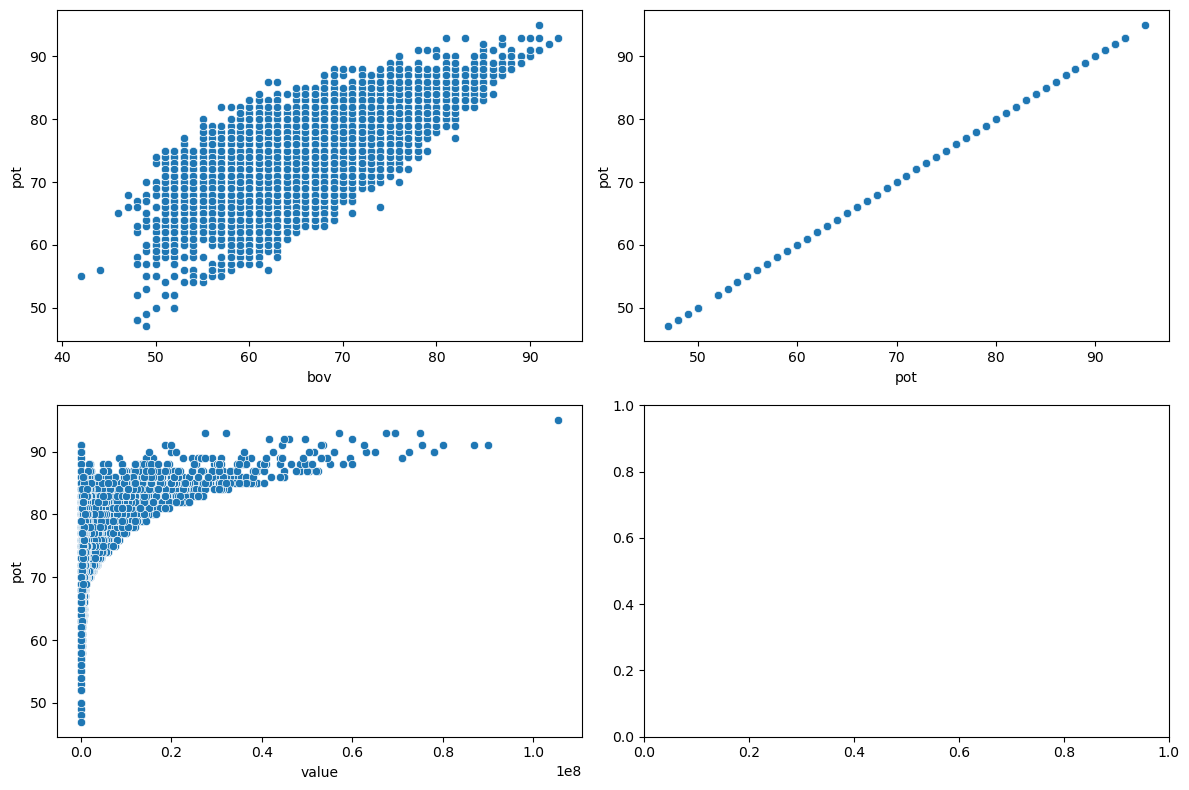

In [113]:
plot_scatter(df_num_3)

In [114]:
# Split Dependent and Independent variables
x_num_1, y = split_numerical(df_num_1, 'pot')
x_num_2, y = split_numerical(df_num_2, 'pot')
x_num_3, y = split_numerical(df_num_3, 'pot')

In [115]:
y

0        69
1        71
2        71
3        82
4        81
         ..
17120    69
17121    66
17122    67
17123    73
17124    74
Name: pot, Length: 17125, dtype: int64

In [116]:
df_log_1 = log_transformer(x_num_1, ['value','hits'])
df_log_2 = log_transformer(x_num_2, ['value'])
df_log_3 = log_transformer(x_num_3, ['value'])

C:\Users\pgarciag\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


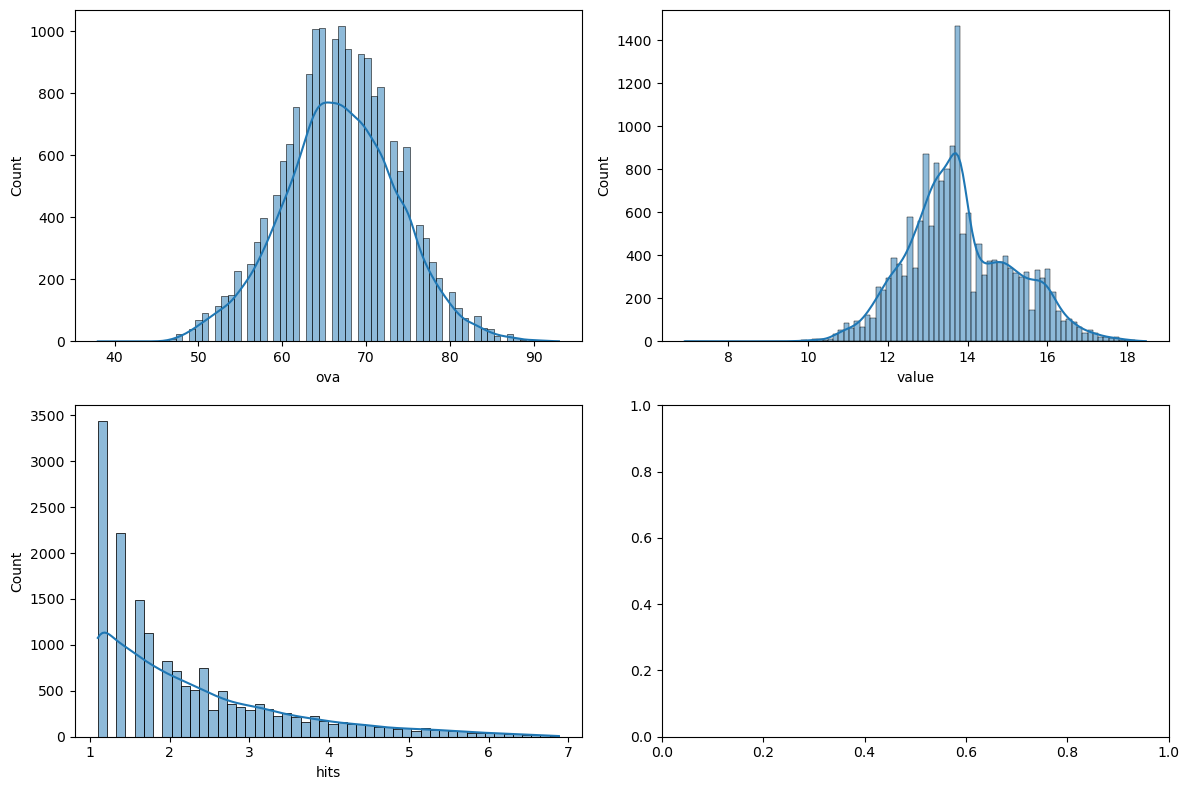

In [117]:
plot_hist(df_log_1)

In [118]:
df_cox_1 = box_cox_transformer(x_num_1, ['value','hits'])
df_cox_2 = box_cox_transformer(x_num_2, ['value'])
df_cox_3 = box_cox_transformer(x_num_3, ['value'])

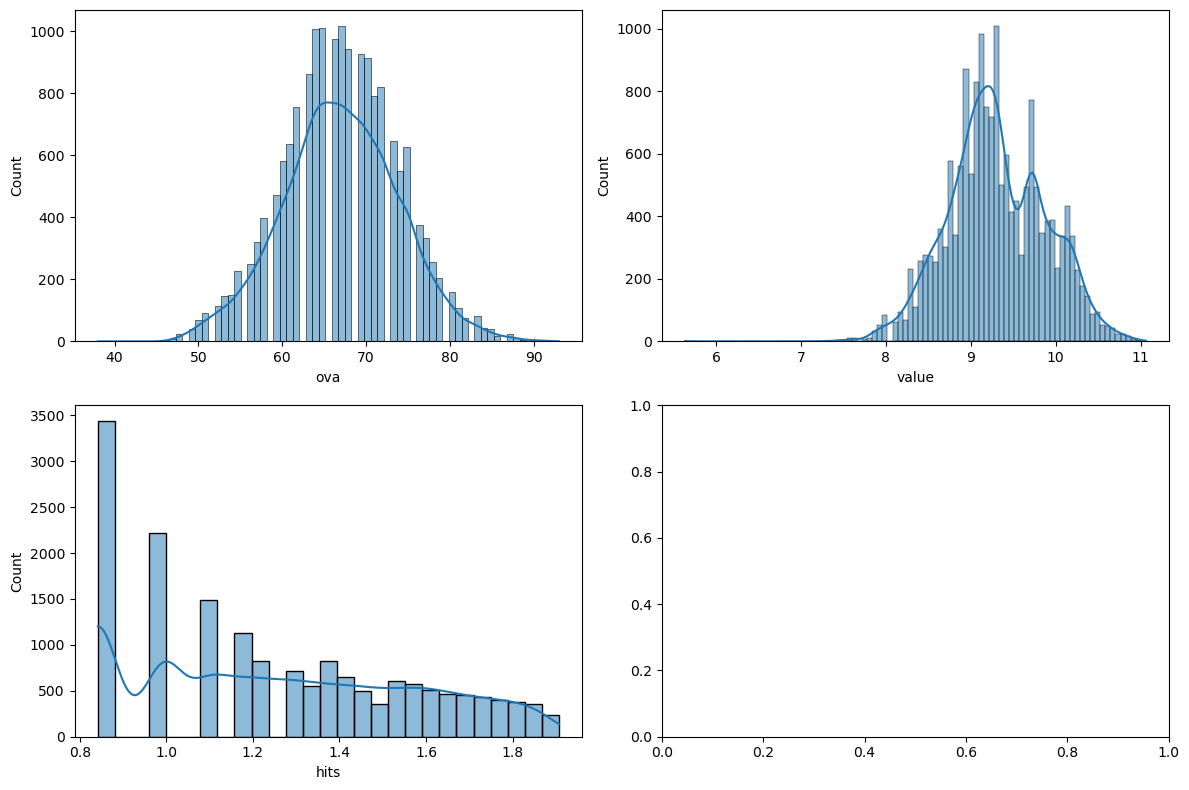

In [119]:
plot_hist(df_cox_1)

In [120]:
# Standarization using MinMax Scaler and Standard Scaler
df_log_minmax_1 =  min_max_scaler(df_log_1)
df_log_minmax_2 =  min_max_scaler(df_log_2)
df_log_minmax_3 =  min_max_scaler(df_log_3)

df_log_std_1 = standard_scaler(df_log_1)
df_log_std_2 = standard_scaler(df_log_2)
df_log_std_3 = standard_scaler(df_log_3)

df_cox_minmax_1 =  min_max_scaler(df_cox_1)
df_cox_minmax_2 =  min_max_scaler(df_cox_2)
df_cox_minmax_3 =  min_max_scaler(df_cox_3)

df_cox_std_1 = standard_scaler(df_cox_1)
df_cox_std_2 = standard_scaler(df_cox_2)
df_cox_std_3 = standard_scaler(df_cox_3)

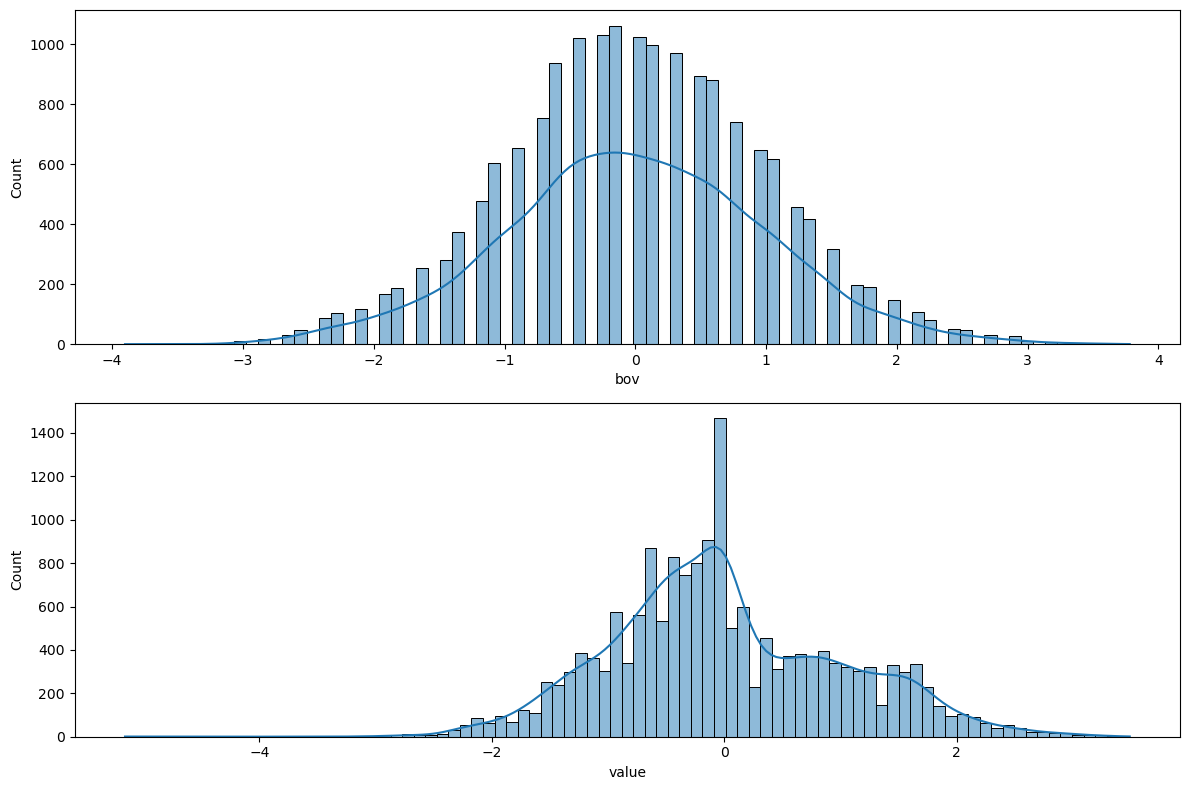

In [121]:
plot_hist(df_log_std_3)

In [122]:
df_log_std_3.head(500)

,bov,value
0,0.467024,-3.435453e-01
1,0.316361,-3.740685e-01
2,0.467024,7.914809e-02
3,0.316361,-1.593850e-14
4,2.124313,1.282548e+00
5,-0.286290,-2.325695e-01
6,1.371000,7.777448e-01
7,1.521662,-5.157146e+00
8,1.521662,-1.593850e-14
9,2.124313,-6.772407e-01


In [123]:
y.shape

(17125,)

In [124]:
# Categorical data workflow 
df_categorical_name = df_categorical['name']
df_categorical_name.head()
# Filter df_categorical data to only keep the ones we think will have higher correlation with 'potencial'
df_categorical_filtered = df.loc[:, ['w/f', 'sm', 'ir']]
df_categorical_filtered.head(100)

,w/f,sm,ir
0,3 ★,2★,2 ★
1,4 ★,3★,1 ★
2,4 ★,4★,2 ★
3,3 ★,1★,1 ★
4,4 ★,4★,4 ★
5,2 ★,3★,2 ★
6,4 ★,4★,2 ★
7,2 ★,3★,3 ★
8,3 ★,2★,3 ★
9,3 ★,3★,2 ★


In [125]:
df_log_std_3.shape

(17125, 2)

In [126]:
y.shape

(17125,)

In [128]:
# Run 1 Model: using attributes 1, 2, 3, 4, 5

# def concat_df(df1, df2):
#     df2 = df2.reset_index(drop=True)
#     df_combined = pd.concat([df1, df2], axis=1, ignore_index=True)
#     df_combined = sm.add_constant(df_combined)
#     return df_combined


# X_train, X_test, y_train, y_test = train_test_split(df_log_std, y, test_size=0.2,random_state=100)

# def linear_regression(X, y):
#     X = sm.add_constant(X) # Add a constant tern to the input data
#     model = sm.OLS(y, X).fit()
#     return model

model_1 = linear_regression(df_log_std_1, y)
model_1.summary()

model_2 = linear_regression(df_log_std_2, y)
model_2.summary()

model_3 = linear_regression(df_log_std_3, y)
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    pot   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     9377.
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        11:35:24   Log-Likelihood:                -47980.
No. Observations:               17125   AIC:                         9.597e+04
Df Residuals:                   17122   BIC:                         9.599e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         72.4898      0.030   2379.675      0.000      72.430      72.550
bov           -1.4290      0.081    -17.734      0.000      -1.587      -1.271
value          5.4594      0.081     67.752      0.000       5.301       5.617
==============================================================================
Omnibus:                     1165.211   Durbin-Watson:                   1.198
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2310.398
Skew:                           0.477   Prob(JB):                         0.00
Kurtosis:                       4.526   Cond. No.                         5.09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [140]:
predicted_y_1 = make_predictions(model_1, df_log_std_1)
predicted_y_2 = make_predictions(model_2, df_log_std_2)
predicted_y_3 = make_predictions(model_3, df_log_std_3)

In [143]:
model_metrics(df_log_std_1, y, model_1)

R2 Score: 0.627 
Mean Squared Error: 12.409 
Root MSE: 3.523 
Mean Absolute Error: 2.713


In [144]:
model_metrics(df_log_std_2, y, model_2)

R2 Score: 0.540 
Mean Squared Error: 15.300 
Root MSE: 3.912 
Mean Absolute Error: 3.082


In [145]:
model_metrics(df_log_std_3, y, model_3)

R2 Score: 0.523 
Mean Squared Error: 15.888 
Root MSE: 3.986 
Mean Absolute Error: 3.194


In [150]:
# Concatenate predicted values with the players name
final_df_1 = concat_df(predicted_y_1, df_categorical_name)
final_df_2 = concat_df(predicted_y_2, df_categorical_name)
final_df_3 = concat_df(predicted_y_3, df_categorical_name)

In [159]:
final_df_1

,const,0,1
0,1.0,68.991521,G. Pasquale
1,1.0,68.446761,Luis García
2,1.0,72.166909,J. Cole
3,1.0,70.042636,D. Yorke
4,1.0,79.783942,Iniesta
...,...,...,...
17120,1.0,70.081821,A. Medioub
17121,1.0,67.437522,W. Rickard
17122,1.0,66.478410,C. Barrett
17123,1.0,70.063567,J. Gazibegović


In [164]:
# Display the top three players 
top_three_indices_1 = final_df_1[0].nlargest(10).index
top_three_1 = final_df_1.loc[top_three_indices_1]


top_three_indices_2 = final_df_2[0].nlargest(10).index
top_three_2 = final_df_2.loc[top_three_indices_2]

top_three_indices_3 = final_df_3[0].nlargest(10).index
top_three_3 = final_df_3.loc[top_three_indices_3]


In [165]:
top_three_1

,const,0,1
5736,1.0,88.825920,J. Kimmich
12361,1.0,88.508083,João Félix
2650,1.0,88.507821,Neymar Jr
9265,1.0,88.414848,L. Martínez
11282,1.0,88.354921,F. Valverde
8856,1.0,88.327460,Oyarzabal
5627,1.0,88.252989,T. Werner
10202,1.0,88.199111,A. Hakimi
4035,1.0,88.118993,M. Depay
4680,1.0,88.015828,S. Gnabry


In [166]:
top_three_2

,const,0,1
9331,1.0,86.566691,K. Mbappé
9633,1.0,85.630222,J. Sancho
4049,1.0,85.486867,R. Sterling
2650,1.0,85.477400,Neymar Jr
3961,1.0,85.388556,H. Kane
5425,1.0,85.388556,P. Dybala
10354,1.0,85.382009,K. Havertz
2871,1.0,85.317982,K. De Bruyne
5633,1.0,85.168486,Bruno Fernandes
5030,1.0,85.146562,S. Mané


In [167]:
top_three_3

,const,0,1
9331,1.0,86.576817,K. Mbappé
2650,1.0,85.928166,Neymar Jr
2871,1.0,85.789776,K. De Bruyne
4049,1.0,85.691417,R. Sterling
3961,1.0,85.606074,H. Kane
5030,1.0,85.559313,S. Mané
5109,1.0,85.559313,M. Salah
2287,1.0,85.447364,R. Lewandowski
4166,1.0,85.426333,V. van Dijk
5425,1.0,85.390776,P. Dybala
